# Solution Part:
* Data Understanding
* Data Exploration
* Data Cleaning
* Data Preparation/Feature Engineering
* Model Building
* Model Evaluation

In [74]:
#Import all the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [77]:
pd.set_option('display.max_rows', None)

In [78]:
#Read the dataset
cars = pd.read_csv('Customer Database.csv', encoding='latin1')
cars_test = pd.read_excel('OH VINs w. Zips.xlsx')
cars_test_original = cars_test.copy()

In [79]:
cars_test['Location'] = 'OHIO'

In [80]:
cars.count()

Location            1140052
sale_date           1140052
gross_sale_price    1140052
mileage             1140052
make                 419587
model                419589
model_year          1130944
color               1129964
grade                685039
drivable             971364
dtype: int64

In [81]:
cars.isnull().sum()

Location                 0
sale_date                0
gross_sale_price         0
mileage                  0
make                720465
model               720463
model_year            9108
color                10088
grade               455013
drivable            168688
dtype: int64

Data Exploration

In [82]:
cars = cars.drop(['color','sale_date'], axis=1)
cars_test = cars_test.drop(['VIN','Auction lights - Green','Auction lights - Red','Zip','Transport Operable','Transport Inop','Representation','Sold Date'], axis=1)

In [83]:
# Step 1: Rename the columns
cars_test = cars_test.rename(columns={
    'Year': 'model_year',
    'Make': 'make',
    'Model': 'model',
    'Mileage': 'mileage',
    'Vehicle Grade (Approved CR)': 'grade',
    'Operable': 'drivable',
})

# Step 2: Format the sale_date as YYYYMMDD
# cars_test['sale_date'] = pd.to_datetime(cars_test['sale_date'], errors='coerce').dt.strftime('%Y%m%d').astype(int)

# Step 3: Remove 'Grade ' prefix from the grade column
cars_test['grade'] = (
    cars_test['grade']
        .str.replace('Grade', '', regex=False)
        .str.replace(': Salvage', '', regex=False)
        .str.replace('Unknown', '', regex=False)
        .replace('', np.nan)  # ← handles empty strings
)

cars_test['drivable'] = cars_test['drivable'].replace('Yes', 'Y')


cars_test['grade'] = pd.to_numeric(cars_test['grade'], errors='coerce')


In [84]:
def feature_engineering(df):
    # Fill missing model_year if any (optional)
    df["model_year"] = df["model_year"].fillna(df["model_year"].median())
    df["model_year"] = df["model_year"].astype(int)

    # Vehicle age
    df["vehicle_age"] = 2025 - df["model_year"]

    # Avoid div by zero
    df["vehicle_age"] = df["vehicle_age"].replace(0, 0.5)

    # Encode drivable
    df["drivable_flag"] = (df["drivable"] == "Y").astype(int)

    # Encode make
    df["make_code"] = df["make"].astype("category").cat.codes

    # Mileage * Age interaction
    df["mileage_age"] = df["mileage"] * df["vehicle_age"]
    df["grade_drivable"] = df["grade"] * df["drivable_flag"]


    # Buckets
    df["mileage_bucket"] = pd.cut(df["mileage"], bins=[0,50000,100000,150000,200000,300000], labels=False)
    df["age_bucket"] = pd.cut(df["vehicle_age"], bins=[0,3,5,8,12,20], labels=False)

    return df

In [85]:
cars = feature_engineering(cars)
cars_test = feature_engineering(cars_test)

In [86]:
cars_test.head()

,model_year,make,model,mileage,grade,drivable,gross_sale_price,Location,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_bucket,age_bucket
0,2013,CHEVROLET,EQUINOX,114069,2.0,Y,3600.000000,OHIO,12,1,6,1368828,2.0,2.0,3
1,2013,ACURA,ILX,92052,2.7,Y,13271.428571,OHIO,12,1,0,1104624,2.7,1.0,3
2,2015,JEEP,WRANG UNLTD,98082,2.7,Y,13000.000000,OHIO,10,1,17,980820,2.7,1.0,3
3,2015,JEEP,COMPASS 4X4 4C,105313,2.8,Y,9800.000000,OHIO,10,1,17,1053130,2.8,2.0,3
4,2016,JEEP,CHEROKEE FWD 4C,118073,2.8,Y,5000.000000,OHIO,9,1,17,1062657,2.8,2.0,3


In [87]:
cars.head()

,Location,gross_sale_price,mileage,make,model,model_year,grade,drivable,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_bucket,age_bucket
0,ALBANY,450,161698,HYUNDAI,Sonata,2010,NaN,N,15.0,0,107,2425470.0,NaN,3.0,4.0
1,ALBANY,550,241828,KIA,Sorento,2011,NaN,Y,14.0,1,134,3385592.0,NaN,4.0,4.0
2,ALBANY,600,154306,JEEP,Compass,2014,NaN,Y,11.0,1,126,1697366.0,NaN,3.0,3.0
3,ALBANY,600,167461,KIA,Sedona,2016,NaN,Y,9.0,1,134,1507149.0,NaN,3.0,3.0
4,ALBANY,800,190512,CHRYSLER,Town & Country LWB,2007,NaN,Y,18.0,1,42,3429216.0,NaN,3.0,4.0


In [88]:
cars_numeric = cars.select_dtypes(include=['float64','int64'])

In [89]:
cars_numeric.corr()

,gross_sale_price,mileage,model_year,grade,vehicle_age,drivable_flag,mileage_age,grade_drivable,mileage_bucket,age_bucket
gross_sale_price,1.000000,-0.571812,0.279437,0.516759,-0.279299,0.096156,-0.449308,0.508838,-0.577642,-0.643773
mileage,-0.571812,1.000000,-0.302670,-0.395685,0.302582,-0.110005,0.736611,-0.384925,0.963728,0.648607
model_year,0.279437,-0.302670,1.000000,0.279189,-0.999999,0.065851,-0.602261,0.276052,-0.298452,-0.936929
grade,0.516759,-0.395685,0.279189,1.000000,-0.279170,0.453208,-0.342141,0.944236,-0.393441,-0.350197
vehicle_age,-0.279299,0.302582,-0.999999,-0.279170,1.000000,-0.065858,0.602237,-0.276033,0.298377,0.936920
drivable_flag,0.096156,-0.110005,0.065851,0.453208,-0.065858,1.000000,-0.107807,0.659489,-0.110430,-0.121902
mileage_age,-0.449308,0.736611,-0.602261,-0.342141,0.602237,-0.107807,1.000000,-0.336706,0.690769,0.775703
grade_drivable,0.508838,-0.384925,0.276052,0.944236,-0.276033,0.659489,-0.336706,1.000000,-0.381898,-0.342111
mileage_bucket,-0.577642,0.963728,-0.298452,-0.393441,0.298377,-0.110430,0.690769,-0.381898,1.000000,0.652755
age_bucket,-0.643773,0.648607,-0.936929,-0.350197,0.936920,-0.121902,0.775703,-0.342111,0.652755,1.000000


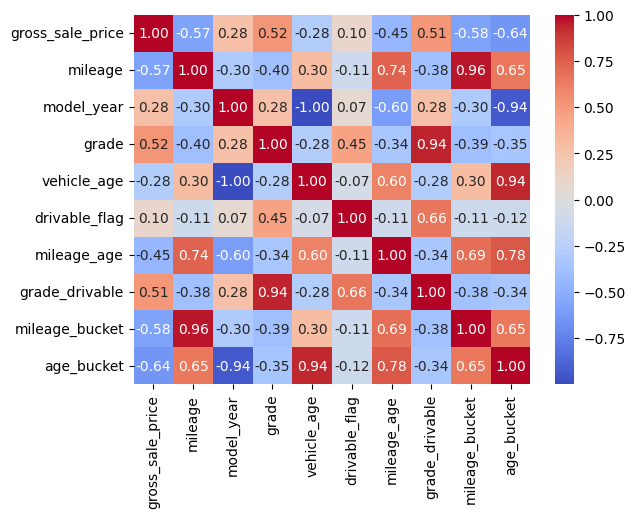

In [90]:
sns.heatmap(cars_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [18]:
#Correlation plot
cor = cars_numeric.corr()
cor

,gross_sale_price,mileage,model_year,grade,vehicle_age,drivable_flag,mileage_age,grade_drivable,mileage_bucket,age_bucket,make_avg_price
gross_sale_price,1.000000,-0.571812,0.279437,0.516759,-0.279299,0.096156,-0.449308,0.508838,-0.577642,-0.643773,0.340872
mileage,-0.571812,1.000000,-0.302670,-0.395685,0.302582,-0.110005,0.736611,-0.384925,0.963728,0.648607,-0.055428
model_year,0.279437,-0.302670,1.000000,0.279189,-0.999999,0.065851,-0.602261,0.276052,-0.298452,-0.936929,0.053300
grade,0.516759,-0.395685,0.279189,1.000000,-0.279170,0.453208,-0.342141,0.944236,-0.393441,-0.350197,0.088378
vehicle_age,-0.279299,0.302582,-0.999999,-0.279170,1.000000,-0.065858,0.602237,-0.276033,0.298377,0.936920,-0.053260
drivable_flag,0.096156,-0.110005,0.065851,0.453208,-0.065858,1.000000,-0.107807,0.659489,-0.110430,-0.121902,0.020260
mileage_age,-0.449308,0.736611,-0.602261,-0.342141,0.602237,-0.107807,1.000000,-0.336706,0.690769,0.775703,-0.053250
grade_drivable,0.508838,-0.384925,0.276052,0.944236,-0.276033,0.659489,-0.336706,1.000000,-0.381898,-0.342111,0.083865
mileage_bucket,-0.577642,0.963728,-0.298452,-0.393441,0.298377,-0.110430,0.690769,-0.381898,1.000000,0.652755,-0.066100
age_bucket,-0.643773,0.648607,-0.936929,-0.350197,0.936920,-0.121902,0.775703,-0.342111,0.652755,1.000000,-0.086830


In [19]:
cars.isnull().sum()

Location                 0
gross_sale_price         0
mileage                  0
make                720465
model               720463
model_year               0
grade               455013
drivable            168688
vehicle_age              0
drivable_flag            0
make_code                0
mileage_age              0
grade_drivable      455013
mileage_bucket        7856
age_bucket           36079
make_avg_price      720465
dtype: int64

Data Preparation

In [20]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute   import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [21]:
cars.head()

,Location,gross_sale_price,mileage,make,model,model_year,grade,drivable,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_bucket,age_bucket,make_avg_price
0,ALBANY,450,161698,HYUNDAI,Sonata,2010,NaN,N,15.0,0,107,2425470.0,NaN,3.0,4.0,6721.075413
1,ALBANY,550,241828,KIA,Sorento,2011,NaN,Y,14.0,1,134,3385592.0,NaN,4.0,4.0,7329.213192
2,ALBANY,600,154306,JEEP,Compass,2014,NaN,Y,11.0,1,126,1697366.0,NaN,3.0,3.0,11927.161396
3,ALBANY,600,167461,KIA,Sedona,2016,NaN,Y,9.0,1,134,1507149.0,NaN,3.0,3.0,7329.213192
4,ALBANY,800,190512,CHRYSLER,Town & Country LWB,2007,NaN,Y,18.0,1,42,3429216.0,NaN,3.0,4.0,7495.334259


In [ ]:
# remove engine from your list of categoricals...
categorical_feats = [
    'make','model','Location','drivable'
]

# …and add it into numeric_feats
numeric_feats = [
    'mileage','model_year','grade','vehicle_age','drivable_flag','make_code','mileage_age','grade_drivable','mileage_bucket','age_bucket'
]

In [23]:
from scipy.stats import skew
skewness = skew(cars['grade'].dropna())
print("Skewness:", skewness)

Skewness: -0.5438853494989186


In [24]:
X_external = cars_test[numeric_feats + categorical_feats]

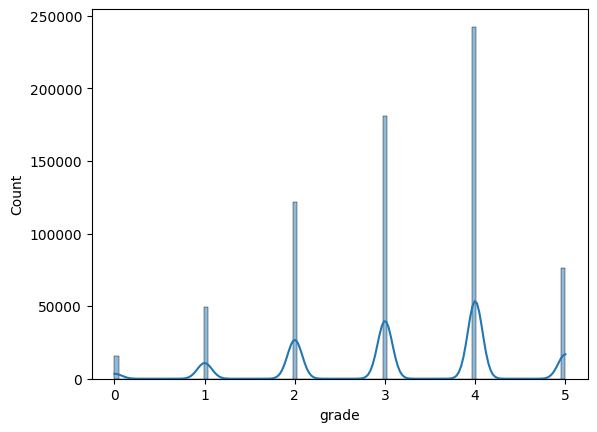

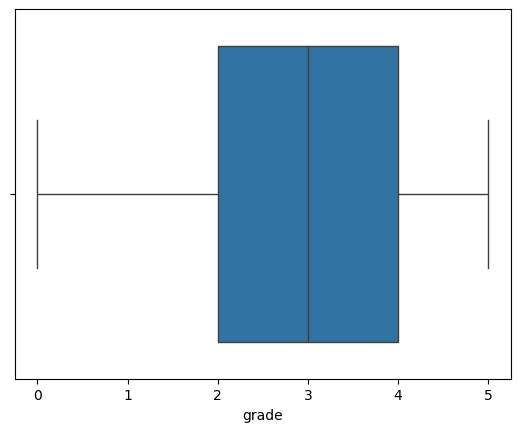

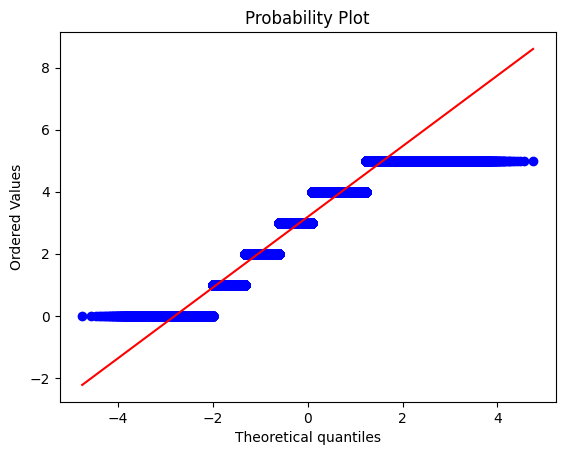

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.histplot(cars['grade'], kde=True)
plt.show()

sns.boxplot(x=cars['grade'])
plt.show()

stats.probplot(cars['grade'].dropna(), dist="norm", plot=plt)
plt.show()

In [26]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
X = cars[numeric_feats + categorical_feats]
y = cars['gross_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42
)

In [29]:
# 4. Helper to build a full pipeline + extract coef names
def make_model_pipeline(model, poly=False):
    steps = []
    if poly:
        # expand numeric features to polynomial degree 2
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
    steps.append(('preproc', preprocessor))
    steps.append(('reg', model))
    return Pipeline(steps)

def get_feature_names(pipeline):
    """
    After fitting, get the transformed feature names in order, so you can map back to coefficients.
    Requires sklearn ≥ 1.0 for ColumnTransformer.get_feature_names_out.
    """
    # name from the 'preproc' step
    feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
    if 'poly' in pipeline.named_steps:
        # if polynomial, get names from poly step
        feat_names = pipeline.named_steps['poly'].get_feature_names_out(feat_names)
    return feat_names

In [30]:
# Linear Regression

lin_pipe = make_model_pipeline(LinearRegression())
lin_pipe.fit(X_train, y_train)
lin_preds = lin_pipe.predict(X_test)

lin_r2 = r2_score(y_test, lin_preds)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_mape = mean_absolute_percentage_error(y_test, lin_preds)

lin_feat_names = get_feature_names(lin_pipe)
lin_coefs = lin_pipe.named_steps['reg'].coef_
lin_coef_df = pd.DataFrame({'feature': lin_feat_names, 'coef': lin_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [31]:
#Lasso Regression (α=0.5)
lasso_pipe = make_model_pipeline(Lasso(alpha=0.5, max_iter=10_000))
lasso_pipe.fit(X_train, y_train)
lasso_preds = lasso_pipe.predict(X_test)

lasso_r2 = r2_score(y_test, lasso_preds)
lasso_mae = mean_absolute_error(y_test, lasso_preds)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mape = mean_absolute_percentage_error(y_test, lasso_preds)

lasso_feat_names = get_feature_names(lasso_pipe)
lasso_coefs = lasso_pipe.named_steps['reg'].coef_
lasso_coef_df = pd.DataFrame({'feature': lasso_feat_names, 'coef': lasso_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [32]:
# Ridge Regression (α=0.5)
ridge_pipe = make_model_pipeline(Ridge(alpha=0.5))
ridge_pipe.fit(X_train, y_train)
ridge_preds = ridge_pipe.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_preds)
ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mape = mean_absolute_percentage_error(y_test, ridge_preds)

ridge_feat_names = get_feature_names(ridge_pipe)
ridge_coefs = ridge_pipe.named_steps['reg'].coef_
ridge_coef_df = pd.DataFrame({'feature': ridge_feat_names, 'coef': ridge_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [35]:
# For polynomial model only
poly_num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

poly_preprocessor = ColumnTransformer([
    ('num', poly_num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

poly_pipe = Pipeline([
    ('preproc', poly_preprocessor),
    ('reg', LinearRegression())
])

poly_pipe.fit(X_train, y_train)
poly_preds = poly_pipe.predict(X_test)

poly_r2 = r2_score(y_test, poly_preds)
poly_mae = mean_absolute_error(y_test, poly_preds)
poly_mse = mean_squared_error(y_test, poly_preds)
poly_rmse = np.sqrt(poly_mse)
poly_mape = mean_absolute_percentage_error(y_test, poly_preds)

poly_feat_names = poly_pipe.named_steps['preproc'].get_feature_names_out()
poly_coefs = poly_pipe.named_steps['reg'].coef_
poly_coef_df = pd.DataFrame({'feature': poly_feat_names, 'coef': poly_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [36]:
# Results
def print_results(name, r2, mae, mse, rmse, mape, coef_df):
    print(f"\n=== {name} ===")
    print("Metrics:")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print("\nTop coefficients:")
    print(coef_df.head(10).to_string(index=False))
    
print_results("Linear", lin_r2, lin_mae, lin_mse, lin_rmse, lin_mape, lin_coef_df)


=== Linear ===
Metrics:
  R2:   0.6347
  MAE:  4392.1519
  MSE:  48686666.8849
  RMSE: 6977.5832
  MAPE: 1.3386

Top coefficients:
              feature           coef
     cat__model_765LT  313701.766950
      num__model_year  237449.418955
     num__vehicle_age  237128.415991
       cat__model_SLS  138815.257411
      cat__model_MC20  120991.044314
       cat__model_360 -119033.297984
  cat__model_GALLARDO -102290.753791
  cat__model_CULLINAN  101369.962463
cat__model_ESCALADE V  100503.382223
        cat__model_R8   98489.730142


In [37]:
print_results("Lasso α=0.5", lasso_r2, lasso_mae, lasso_mse, lasso_rmse, lasso_mape, lasso_coef_df)


=== Lasso α=0.5 ===
Metrics:
  R2:   0.6170
  MAE:  4480.2380
  MSE:  51049780.9162
  RMSE: 7144.9129
  MAPE: 1.2514

Top coefficients:
               feature         coef
    cat__model_G-Class 84926.368023
        cat__model_911 76643.228444
          cat__model_G 64513.626881
         cat__model_R8 48467.231320
     cat__model_AMG GT 41038.013095
       cat__model_F450 33478.939104
   cat__model_CORVETTE 31208.368450
      cat__model_F-450 28611.423063
   cat__model_ESCALADE 27054.232452
cat__model_RANGE ROVER 25861.969225


In [38]:
print_results("Ridge α=0.5", ridge_r2, ridge_mae, ridge_mse, ridge_rmse, ridge_mape, ridge_coef_df)


=== Ridge α=0.5 ===
Metrics:
  R2:   0.6344
  MAE:  4395.3793
  MSE:  48727120.8924
  RMSE: 6980.4814
  MAPE: 1.3349

Top coefficients:
              feature          coef
      num__model_year 170811.284996
     num__vehicle_age 170497.751699
     cat__model_765LT 163675.597852
      cat__model_MC20 116758.124018
cat__model_ESCALADE V  97620.838208
     cat__model_Ghost -92538.846593
        cat__model_R8  87111.910626
  cat__model_GALLARDO -85263.192611
         cat__model_G  83700.252828
  cat__model_CULLINAN  83095.259027


In [39]:
print_results("Polynomial Degree=2", poly_r2, poly_mae, poly_mse, poly_rmse, poly_mape, poly_coef_df)


=== Polynomial Degree=2 ===
Metrics:
  R2:   0.6442
  MAE:  3917.9978
  MSE:  47418746.0175
  RMSE: 6886.1271
  MAPE: 0.9048

Top coefficients:
              feature           coef
     cat__model_765LT  253007.354609
     cat__make_SHELBY  239567.642713
       cat__model_SLS  147045.110785
      cat__model_MC20  107924.728513
    cat__model_Artura -107360.456625
      cat__model_Roma  -96751.553437
        cat__model_R8   94223.392207
 cat__model_R8 Spyder   89674.055747
cat__model_ESCALADE V   86815.089174
cat__model_488 SPIDER   84648.552380


In [40]:
# 4) Full pipeline with RF
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf',      RandomForestRegressor(
                    n_estimators=231,
                    max_depth=40,
                    min_samples_leaf=2,
                    max_features='log2',
                    random_state=42
               ))
])

In [41]:
# 5) Fit!
pipeline.fit(X_train, y_train)    # should now run without the NaN error

Pipeline(steps=[('preproc',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['mileage', 'model_year',
                                                   'grade', 'vehicle_age',
                                                   'drivable_flag', 'make_code',
                                                   'mileage_age',
                                                   'grade_drivable',
                                                   'mileage_bucket',
                                                   'age_bucket',
                                                   'make_avg_price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'model', 'Location',
                                                   'drivable'])])),
                ('rf',
                 RandomForestRegressor(max_depth=40, max_features='log2',
                                       min_samples_leaf=2, n_estimators=231,
                                       random_state=42))])

In [42]:
# 6a. …and get predictions directly on new data:
rf_predictions = pipeline.predict(X_test)

In [43]:
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

# Display results
print("📊 Random Forest Regression Evaluation Metrics")
print(f"R² Score  : {rf_r2:.4f}")
print(f"MAE       : {rf_mae:.2f}")
print(f"MSE       : {rf_mse:.2f}")
print(f"RMSE      : {rf_rmse:.2f}")
print(f"MAPE      : {rf_mape:.2%}")

📊 Random Forest Regression Evaluation Metrics
R² Score  : 0.4758
MAE       : 5392.72
MSE       : 69867298.19
RMSE      : 8358.67
MAPE      : 199.24%


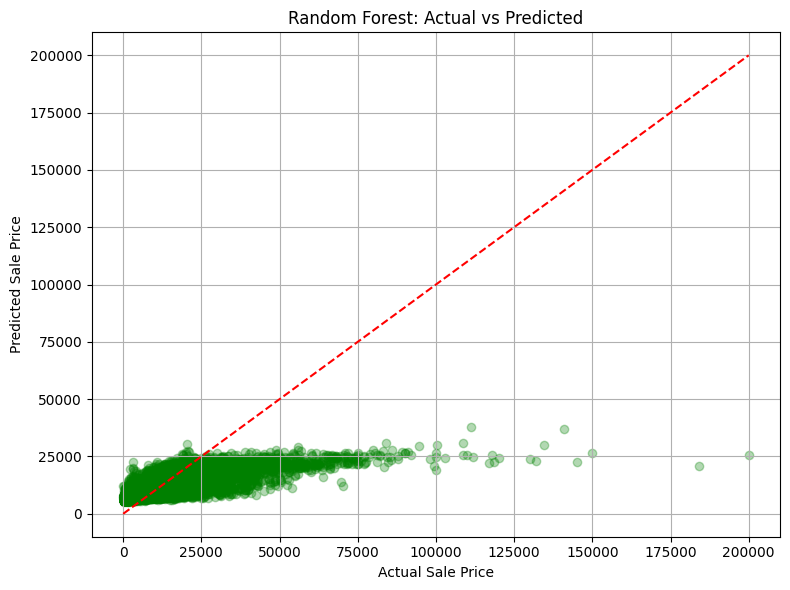

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost

In [45]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

In [ ]:
# def xgb_evaluate(max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight, reg_alpha, reg_lambda, n_jobs=-1):    
#     max_depth = int(max_depth)
#     min_child_weight = int(min_child_weight)

#     model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         use_label_encoder=False,
#         random_state=0,
#         n_estimators=200,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda,
#         n_jobs=n_jobs
# )
    
#     xgb_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('xgb',     model)
#     ])

#     xgb_pipeline.fit(X_train, y_train)

#     y_pred = xgb_pipeline.predict(X_test)

#     return r2_score(y_test, y_pred)

# pbounds = {
#     'max_depth': (3, 10),                
#     'learning_rate': (0.01, 0.5),        
#     'subsample': (0.5, 1.0),             
#     'colsample_bytree': (0.5, 1.0),      
#     'gamma': (0, 5),                    
#     'min_child_weight': (1, 10),        
#     'reg_alpha': (0, 1),                
#     'reg_lambda': (0, 5)                
# }


# optimizer = BayesianOptimization(
#     f=xgb_evaluate,        
#     pbounds=pbounds,      
#     random_state=42,       
#     verbose=2              
# )

# optimizer.maximize(init_points=5, n_iter=100)

# print('The best Hyperparameters:', optimizer.max['params'])
# print('The best Accuracy: {:.4f}'.format(optimizer.max['target']))


|   iter    |  target   | max_depth | learni... | subsample | colsam... |   gamma   | min_ch... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7411167 | 5.6217808 | 0.4758500 | 0.8659969 | 0.7993292 | 0.7800932 | 2.4039506 | 0.0580836 | 4.3308807 |
| 2         | 0.7427364 | 7.2078050 | 0.3569555 | 0.5102922 | 0.9849549 | 4.1622132 | 2.9110519 | 0.1818249 | 0.9170225 |
| 3         | 0.7314857 | 5.1296957 | 0.2671306 | 0.7159725 | 0.6456145 | 3.0592644 | 2.2554447 | 0.2921446 | 1.8318092 |
| 4         | 0.7405136 | 6.1924898 | 0.3947362 | 0.5998368 | 0.7571172 | 2.9620728 | 1.4180537 | 0.6075448 | 0.8526206 |
| 5         | 0.7228010 | 3.4553611 | 0.4749539 | 0.9828160 | 0.9041986 | 1.5230688 | 1.8790490 | 0.6842330 | 2.2007624 |
| 6         | 0.7382148 | 8.0118887 | 0.4678956 | 0.5       | 0.9449410 | 3.6484927 | 1.5456074 | 0.5841664 | 0.0919815 |
| 7         | 0.7432507 

In [ ]:
# import optuna
# from xgboost import XGBRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score

# def objective(trial):
#     # 1) sample hyperparams
#     max_depth         = trial.suggest_int("max_depth", 3, 10)
#     learning_rate     = trial.suggest_float("learning_rate", 0.01, 0.5)
#     subsample         = trial.suggest_float("subsample", 0.5, 1.0)
#     colsample_bytree  = trial.suggest_float("colsample_bytree", 0.5, 1.0)
#     gamma             = trial.suggest_float("gamma", 0.0, 5.0)
#     min_child_weight  = trial.suggest_int("min_child_weight", 1, 10)
#     reg_alpha         = trial.suggest_float("reg_alpha", 0.0, 1.0)
#     reg_lambda         = trial.suggest_float("reg_lambda", 0.0, 5.0)
#     # n_jobs can stay fixed at -1, or you could expose it too

#     # 2) build model + pipeline
#     model = XGBRegressor(
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         use_label_encoder=False,
#         random_state=0,
#         n_estimators=200,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda,
#         n_jobs=-1
#     )
#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('xgb',      model)
#     ])

#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)

#     return r2_score(y_test, y_pred)

# # 4) create study & optimize
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=100, n_jobs=1)

# print("Best R²: {:.4f}".format(study.best_value))
# print("Best hyperparameters:")
# for k, v in study.best_params.items():
#     print(f"  {k}: {v}")

[I 2025-07-21 16:19:53,292] A new study created in memory with name: no-name-36e94793-0274-4fc4-9e6d-de5ef1009b1c
[I 2025-07-21 16:20:02,892] Trial 0 finished with value: 0.7411167621612549 and parameters: {'max_depth': 5, 'learning_rate': 0.4758500101408589, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'min_child_weight': 2, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.7411167621612549.
[I 2025-07-21 16:20:13,427] Trial 1 finished with value: 0.7420083284378052 and parameters: {'max_depth': 7, 'learning_rate': 0.35695556312006227, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 3, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.7420083284378052.
[I 2025-07-21 16:20:22,626] Trial 2 finished with value: 0.7314857840538025 and parameters: {'max_depth': 5, 'l

Best R²: 0.7539
Best hyperparameters:
  max_depth: 10
  learning_rate: 0.3599871651563018
  subsample: 0.6846216349155324
  colsample_bytree: 0.878803221981368
  gamma: 3.751747292036414
  min_child_weight: 6
  reg_alpha: 0.21447804994051073
  reg_lambda: 2.030763722434694


In [46]:
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        # fixed hyperparameters from BayesOpt:
        max_depth=10,
        learning_rate=0.5,
        subsample=1.0,
        colsample_bytree=1.0,
        gamma=0.0,
        min_child_weight=5.6884070022627755,
        reg_alpha=0.0,
        reg_lambda=3.297797017784904,
        # keep the rest as before:
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=0,
        n_estimators=200,
        n_jobs=-1
    ))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
print("5-Fold CV R² scores:", cv_scores)
print("Mean CV R²: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


5-Fold CV R² scores: [0.72426718 0.71270049 0.71740437 0.71885616 0.71778369]
Mean CV R²: 0.7182 ± 0.0037


In [47]:
# 3. Fit & predict just like before
xgb_pipeline.fit(X_train, y_train)
xgb_predictions = xgb_pipeline.predict(X_test)
xgb_predictions_external = xgb_pipeline.predict(X_external)

In [48]:
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

# Display results
print("📊 XGBoost Regression Evaluation Metrics")
print(f"R² Score  : {xgb_r2:.4f}")
print(f"MAE       : {xgb_mae:.2f}")
print(f"MSE       : {xgb_mse:.2f}")
print(f"RMSE      : {xgb_rmse:.2f}")
print(f"MAPE      : {xgb_mape:.2%}")

📊 XGBoost Regression Evaluation Metrics
R² Score  : 0.7535
MAE       : 3352.85
MSE       : 32859904.00
RMSE      : 5732.36
MAPE      : 72.81%


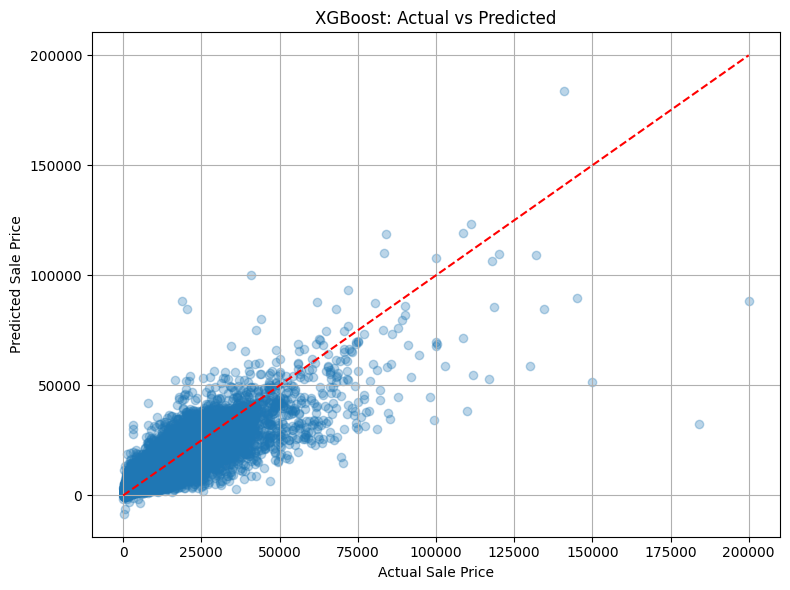

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
import shap
import matplotlib.pyplot as plt

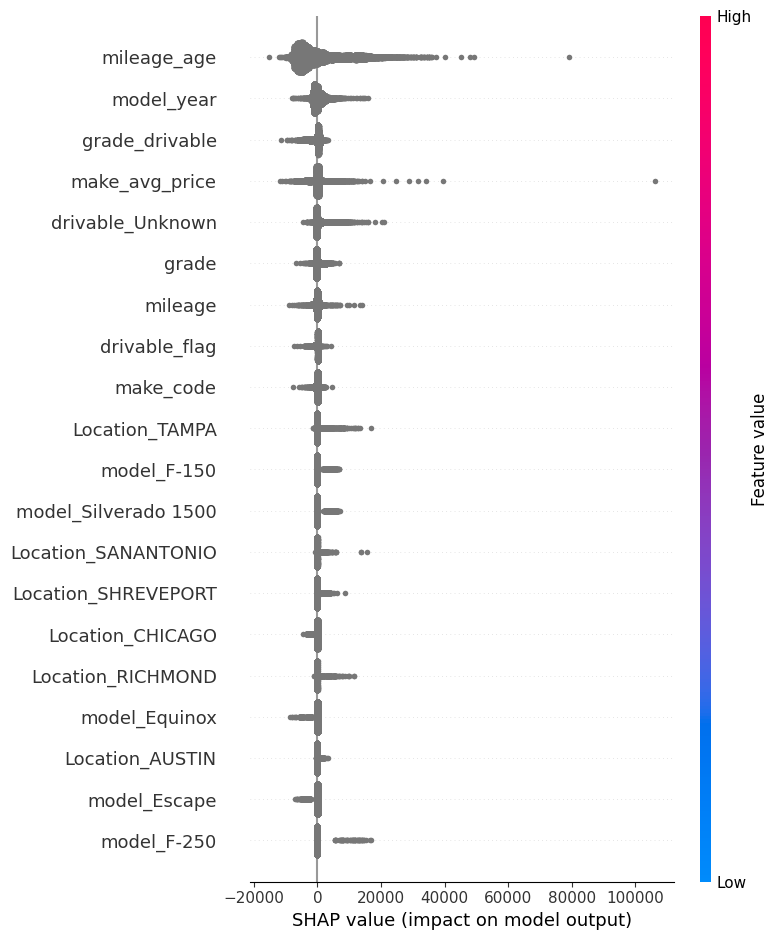

In [51]:
# 1) grab the fitted XGBRegressor
fitted_xgb = xgb_pipeline.named_steps['xgb']

# 2) transform your test set
X_test_trans = xgb_pipeline.named_steps['preproc'].transform(X_test)

# 3) use the tree explainer
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test_trans)

# 4) plot, but you need feature names from the preprocessor
feature_names = numeric_feats + list(xgb_pipeline.named_steps['preproc']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(categorical_feats))
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

In [52]:
import scipy.sparse as sp

# grab the first row of your transformed test set
first_row_sparse = X_test_trans[0]

# convert to a 1-D numpy array
if sp.issparse(first_row_sparse):
    first_row = first_row_sparse.toarray().flatten()
else:
    first_row = first_row_sparse

# now do the force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    first_row,
    feature_names=feature_names
)

CatBoost

In [ ]:
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score
# from bayes_opt import BayesianOptimization

# def catb_evaluate(depth, learning_rate, subsample, rsm, l2_leaf_reg, n_jobs=-1):
#     # cast integer params
#     depth = int(depth)
#     l2_leaf_reg = max(1.0, l2_leaf_reg)  # ensure >0

#     model = CatBoostRegressor(
#         iterations=200,
#         depth=depth,
#         learning_rate=learning_rate,
#         subsample=subsample,         # requires bootstrap_type='Bernoulli'
#         rsm=rsm,                     # feature subsample fraction
#         l2_leaf_reg=l2_leaf_reg,     # L2 regularization
#         bootstrap_type='Bernoulli',
#         random_seed=0,
#         eval_metric='RMSE',
#         silent=True,
#         thread_count=n_jobs
#     )
    
#     catboost_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('catb',    model)
#     ])
    
#     # fit & eval
#     catboost_pipeline.fit(X_train, y_train)
#     catboost_preds = catboost_pipeline.predict(X_test)
    
#     return r2_score(y_test, catboost_preds)


# # define search space (mapping subsample→bagging, rsm→colsample)
# pbounds = {
#     'depth':         (3, 10),
#     'learning_rate': (0.01, 0.3),
#     'subsample':     (0.5, 1.0),
#     'rsm':           (0.5, 1.0),
#     'l2_leaf_reg':   (1, 10),
# }

# optimizer = BayesianOptimization(
#     f=catb_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# optimizer.maximize(init_points=5, n_iter=100)

# print("Best params:", optimizer.max['params'])
# print("Best R²: {:.4f}".format(optimizer.max['target']))


|   iter    |  target   |   depth   | learni... | subsample |    rsm    | l2_lea... |
-------------------------------------------------------------------------------------
| 1         | 0.7246856 | 5.6217808 | 0.2857071 | 0.8659969 | 0.7993292 | 2.4041677 |
| 2         | 0.6493952 | 4.0919616 | 0.0268442 | 0.9330880 | 0.8005575 | 7.3726532 |
| 3         | 0.7015909 | 3.1440914 | 0.2912738 | 0.9162213 | 0.6061695 | 2.6364247 |
| 4         | 0.6878617 | 4.2838315 | 0.0982302 | 0.7623782 | 0.7159725 | 3.6210622 |
| 5         | 0.6897884 | 7.2829702 | 0.0504532 | 0.6460723 | 0.6831809 | 5.1046298 |
| 6         | 0.7350649 | 7.0776557 | 0.3       | 1.0       | 0.5       | 1.0       |
| 7         | 0.7470906 | 10.0      | 0.3       | 0.5       | 1.0       | 1.0       |
| 8         | 0.7456848 | 10.0      | 0.3       | 1.0       | 1.0       | 3.0199872 |
| 9         | 0.7415460 | 10.0      | 0.3       | 1.0       | 1.0       | 10.0      |
| 10        | 0.7408794 | 10.0      | 0.3       | 0.5 

In [53]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.3,
    depth= int(10.0),
    subsample= 0.5,
    rsm= 1.0,
    l2_leaf_reg= 1.0,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)


In [54]:
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('catboost', catboost_model)
])

In [55]:
# Fit the pipeline
catboost_pipeline.fit(X_train, y_train)

# Predict on test data
catboost_preds = catboost_pipeline.predict(X_test)
catboost_preds_external = catboost_pipeline.predict(X_external)

In [56]:
catboost_r2 = r2_score(y_test, catboost_preds)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_mse = mean_squared_error(y_test, catboost_preds)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {catboost_r2:.4f}")
print(f"MAE       : {catboost_mae:.2f}")
print(f"MSE       : {catboost_mse:.2f}")
print(f"RMSE      : {catboost_rmse:.2f}")
print(f"MAPE      : {catboost_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.7519
MAE       : 3391.50
MSE       : 33075701.99
RMSE      : 5751.15
MAPE      : 73.19%


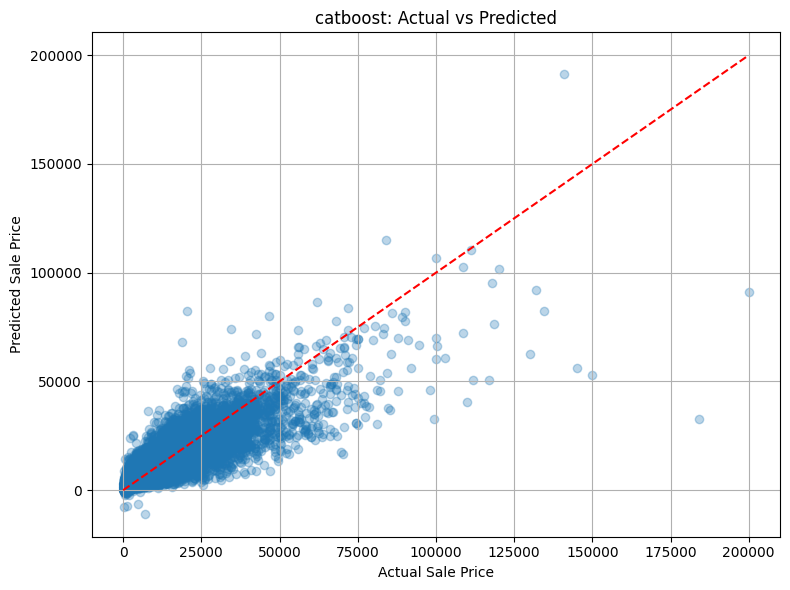

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, catboost_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Native Handling

In [58]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
# Define your categorical and numeric features
categorical_feats = [
    'make','model','Location','drivable'
]
# …and add it into numeric_feats
numeric_feats = [
    'mileage','model_year','grade','vehicle_age','mileage_per_year','drivable_flag','make_code','mileage_age','grade_drivable','mileage_bucket','age_bucket'
]

# Combine for final feature set
all_feats = numeric_feats + categorical_feats


In [60]:
# Fill NaNs in categorical features with a string label (e.g., 'Unknown')
X_train[categorical_feats] = X_train[categorical_feats].fillna('Unknown')
X_test[categorical_feats] = X_test[categorical_feats].fillna('Unknown')

# Create CatBoost Pools to specify categorical columns
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_feats]

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
test_pool = Pool(X_test, cat_features=cat_features_indices)

In [61]:
cat_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.01,
    depth= int(3.741102246131447),
    subsample= 0.6940881708873464,
    rsm= 0.6050881017968055,
    l2_leaf_reg= 6.164449857722794,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

cat_model.fit(train_pool)
cat_preds = cat_model.predict(test_pool)

In [62]:
cat_r2 = r2_score(y_test, cat_preds)
cat_mae = mean_absolute_error(y_test, cat_preds)
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = np.sqrt(cat_mse)
cat_mape = mean_absolute_percentage_error(y_test, cat_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {cat_r2:.4f}")
print(f"MAE       : {cat_mae:.2f}")
print(f"MSE       : {cat_mse:.2f}")
print(f"RMSE      : {cat_rmse:.2f}")
print(f"MAPE      : {cat_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.6292
MAE       : 4298.51
MSE       : 49425026.55
RMSE      : 7030.29
MAPE      : 116.92%


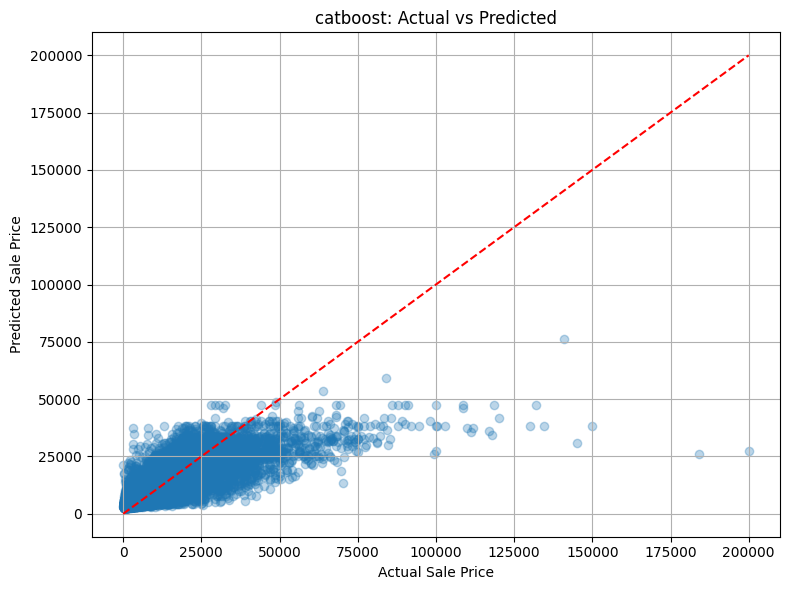

In [63]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Model Combination

In [64]:
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score

In [65]:
# Define the base models with fixed parameters
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.3,
    depth= int(10.0),
    subsample= 0.5,
    rsm= 1.0,
    l2_leaf_reg= 1.0,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

xgb_model =   XGBRegressor(
    # fixed hyperparameters from BayesOpt:
    max_depth=10,
    learning_rate=0.5,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0.0,
    min_child_weight=5.6884070022627755,
    reg_alpha=0.0,
    reg_lambda=3.297797017784904,
    # keep the rest as before:
    objective='reg:squarederror',
    eval_metric='rmse',
    use_label_encoder=False,
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)

In [ ]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# def objective(trial):
#     meta_params = dict(
#         n_estimators     = trial.suggest_int('meta_n_estimators', 25, 300),
#         max_depth        = trial.suggest_int('meta_max_depth', 2, 8),
#         learning_rate    = trial.suggest_float('meta_learning_rate', 1e-3, 0.2, log=True),
#         subsample        = trial.suggest_float('meta_subsample', 0.5, 1.0),
#         colsample_bytree = trial.suggest_float('meta_colsample_bytree', 0.5, 1.0),
#         reg_alpha        = trial.suggest_float('meta_reg_alpha', 0.0, 5.0),
#         reg_lambda       = trial.suggest_float('meta_reg_lambda', 0.0, 10.0),
#         objective        = 'reg:squarederror',
#         eval_metric      = 'rmse',
#         random_state     = 42,
#         n_jobs           = -1
#     )

#     stack = StackingRegressor(
#         estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
#         final_estimator=XGBRegressor(**meta_params),
#         passthrough=False,     # keep fixed unless you want to tune it too
#         n_jobs=-1              # sklearn >=1.4
#     )

#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('stack',   stack)
#     ])

#     scores = cross_val_score(pipe, X_train, y_train,
#                              cv=kf, scoring='r2', n_jobs=-1)
#     return scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print("Best R²:", study.best_value)
# print("Best params:", study.best_params)

# # ---- Refit best model on full train ----
# best = study.best_params
# best_meta = XGBRegressor(
#     n_estimators     = best['meta_n_estimators'],
#     max_depth        = best['meta_max_depth'],
#     learning_rate    = best['meta_learning_rate'],
#     subsample        = best['meta_subsample'],
#     colsample_bytree = best['meta_colsample_bytree'],
#     reg_alpha        = best['meta_reg_alpha'],
#     reg_lambda       = best['meta_reg_lambda'],
#     objective        = 'reg:squarederror',
#     eval_metric      = 'rmse',
#     random_state     = 42,
#     n_jobs           = -1
# )

# final_stack = StackingRegressor(
#     estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
#     final_estimator=best_meta,
#     passthrough=False,
#     n_jobs=-1
# )

# final_pipeline = Pipeline([
#     ('preproc', preprocessor),
#     ('stack',   final_stack)
# ]).fit(X_train, y_train)

# y_pred = final_pipeline.predict(X_test)

[I 2025-07-22 10:54:15,906] A new study created in memory with name: no-name-3aa4d133-1218-45b1-a5bb-5a70a159dea8
Best trial: 0. Best value: 0.707233:   2%|▏         | 1/50 [17:30<14:17:34, 1050.09s/it]

[I 2025-07-22 11:11:45,992] Trial 0 finished with value: 0.7072326064109802 and parameters: {'meta_n_estimators': 284, 'meta_max_depth': 6, 'meta_learning_rate': 0.012174126537392405, 'meta_subsample': 0.8096440669350968, 'meta_colsample_bytree': 0.8590223734501057, 'meta_reg_alpha': 0.9266275571594412, 'meta_reg_lambda': 1.5936936887065767}. Best is trial 0 with value: 0.7072326064109802.


Best trial: 0. Best value: 0.707233:   4%|▍         | 2/50 [33:53<13:28:48, 1011.02s/it]

[I 2025-07-22 11:28:09,665] Trial 1 finished with value: 0.7041293382644653 and parameters: {'meta_n_estimators': 183, 'meta_max_depth': 7, 'meta_learning_rate': 0.014278705577323888, 'meta_subsample': 0.910364997062644, 'meta_colsample_bytree': 0.7297479908894868, 'meta_reg_alpha': 3.7325031066594545, 'meta_reg_lambda': 2.00338270659419}. Best is trial 0 with value: 0.7072326064109802.


Best trial: 0. Best value: 0.707233:   6%|▌         | 3/50 [50:30<13:06:49, 1004.46s/it]

[I 2025-07-22 11:44:46,323] Trial 2 finished with value: 0.6547777771949768 and parameters: {'meta_n_estimators': 213, 'meta_max_depth': 5, 'meta_learning_rate': 0.0061171350567829205, 'meta_subsample': 0.9097823076383251, 'meta_colsample_bytree': 0.613217065646481, 'meta_reg_alpha': 0.15505169489997472, 'meta_reg_lambda': 5.735512936537325}. Best is trial 0 with value: 0.7072326064109802.


Best trial: 3. Best value: 0.70795:   8%|▊         | 4/50 [1:08:09<13:06:29, 1025.85s/it] 

[I 2025-07-22 12:02:24,964] Trial 3 finished with value: 0.7079499721527099 and parameters: {'meta_n_estimators': 239, 'meta_max_depth': 6, 'meta_learning_rate': 0.04828995693987966, 'meta_subsample': 0.845332224450465, 'meta_colsample_bytree': 0.9667404823132861, 'meta_reg_alpha': 2.1027495179423172, 'meta_reg_lambda': 9.775924398369755}. Best is trial 3 with value: 0.7079499721527099.


Best trial: 3. Best value: 0.70795:  10%|█         | 5/50 [1:23:45<12:25:15, 993.68s/it] 

[I 2025-07-22 12:18:01,587] Trial 4 finished with value: 0.6725923895835877 and parameters: {'meta_n_estimators': 254, 'meta_max_depth': 2, 'meta_learning_rate': 0.007061668200506088, 'meta_subsample': 0.8215651988125033, 'meta_colsample_bytree': 0.8112229096802732, 'meta_reg_alpha': 4.182051044179815, 'meta_reg_lambda': 7.129852768000822}. Best is trial 3 with value: 0.7079499721527099.


Best trial: 3. Best value: 0.70795:  12%|█▏        | 6/50 [1:38:49<11:46:21, 963.22s/it]

[I 2025-07-22 12:33:05,675] Trial 5 finished with value: 0.7079285025596619 and parameters: {'meta_n_estimators': 206, 'meta_max_depth': 7, 'meta_learning_rate': 0.09299304440058982, 'meta_subsample': 0.5670121245714661, 'meta_colsample_bytree': 0.7625863721623394, 'meta_reg_alpha': 2.1478397177113266, 'meta_reg_lambda': 6.196981222562546}. Best is trial 3 with value: 0.7079499721527099.


Best trial: 6. Best value: 0.707975:  14%|█▍        | 7/50 [1:54:00<11:17:58, 946.02s/it]

[I 2025-07-22 12:48:16,298] Trial 6 finished with value: 0.7079745531082153 and parameters: {'meta_n_estimators': 232, 'meta_max_depth': 6, 'meta_learning_rate': 0.17852112116215108, 'meta_subsample': 0.6452648417587508, 'meta_colsample_bytree': 0.502565582973248, 'meta_reg_alpha': 2.229844958348264, 'meta_reg_lambda': 5.876127904354212}. Best is trial 6 with value: 0.7079745531082153.


Best trial: 6. Best value: 0.707975:  16%|█▌        | 8/50 [2:09:24<10:57:18, 939.02s/it]

[I 2025-07-22 13:03:40,310] Trial 7 finished with value: 0.629066550731659 and parameters: {'meta_n_estimators': 282, 'meta_max_depth': 4, 'meta_learning_rate': 0.0039399468321803235, 'meta_subsample': 0.7451375256211368, 'meta_colsample_bytree': 0.8327662905681221, 'meta_reg_alpha': 0.5189017692180303, 'meta_reg_lambda': 0.006083640288565562}. Best is trial 6 with value: 0.7079745531082153.


Best trial: 6. Best value: 0.707975:  16%|█▌        | 8/50 [2:12:31<11:35:46, 993.96s/it]


[W 2025-07-22 13:06:47,531] Trial 8 failed with parameters: {'meta_n_estimators': 209, 'meta_max_depth': 8, 'meta_learning_rate': 0.003905971127539129, 'meta_subsample': 0.9013988819220256, 'meta_colsample_bytree': 0.8963524383912007, 'meta_reg_alpha': 4.582412178756782, 'meta_reg_lambda': 8.092351467389141} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ChenChen\AppData\Local\Temp\ipykernel_25784\802679724.py", line 30, in objective
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=kf, scoring='r2', n_jobs=-1)
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\skle

KeyboardInterrupt: 

In [66]:
# 3) Build the stacking regressor
stack = StackingRegressor(
    estimators=[
        ('Cat',  catboost_model),
        ('xgb', xgb_model)
    ],
    final_estimator=XGBRegressor(
        n_estimators=50,
        learning_rate=0.1,
        random_state=42
    ),
    # passthrough=True  # if you want the original features concatenated to meta‑features
)

# 4) Put it all in one pipeline
stacking_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('stack',   stack)
])

# 5) Fit & evaluate
stacking_pipeline.fit(X_train, y_train)
y_pred = stacking_pipeline.predict(X_test)
y_pred_external = stacking_pipeline.predict(X_external)

#print("Stacked R²:", r2_score(y_test, y_pred))

In [67]:
y_r2 = r2_score(y_test, y_pred)
y_mae = mean_absolute_error(y_test, y_pred)
y_mse = mean_squared_error(y_test, y_pred)
y_rmse = np.sqrt(y_mse)
y_mape = mean_absolute_percentage_error(y_test, y_pred)

# Display results
print("📊 stack Regression Evaluation Metrics")
print(f"R² Score  : {y_r2:.4f}")
print(f"MAE       : {y_mae:.2f}")
print(f"MSE       : {y_mse:.2f}")
print(f"RMSE      : {y_rmse:.2f}")
print(f"MAPE      : {y_mape:.2%}")

📊 stack Regression Evaluation Metrics
R² Score  : 0.7517
MAE       : 3347.28
MSE       : 33094814.00
RMSE      : 5752.81
MAPE      : 73.60%


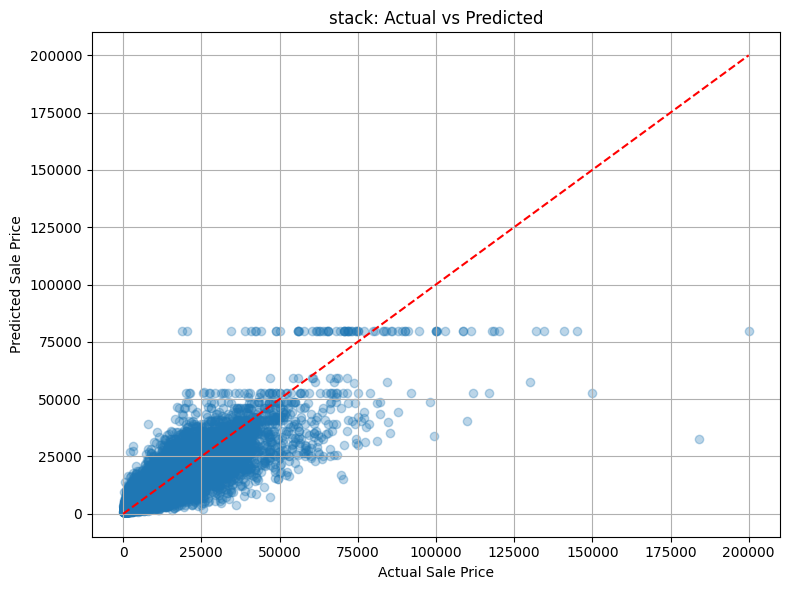

In [68]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('stack: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualize the actual prices and Predicted prices

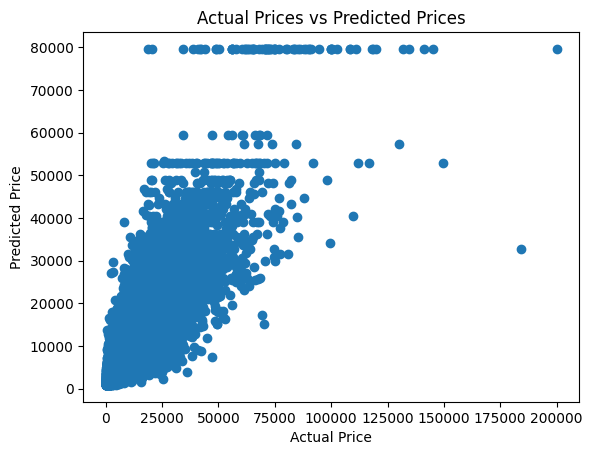

In [69]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

Final Model Evaluation

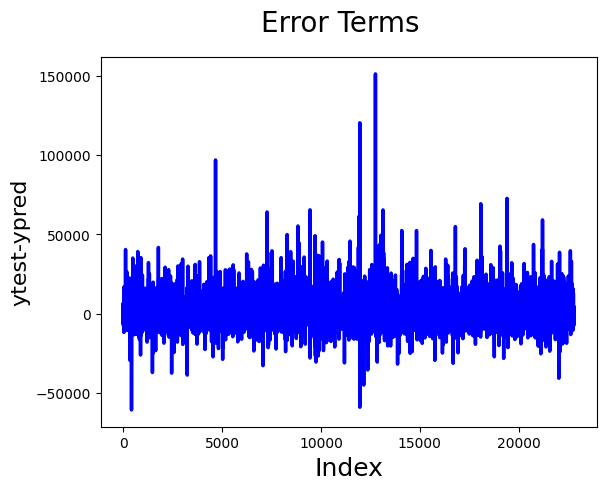

In [70]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

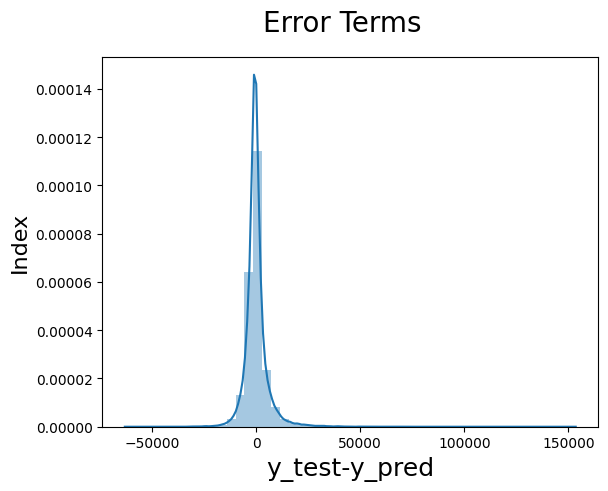

In [71]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

Export the Predictions

In [72]:
# 1) Extract the true y values for X_external
y_external = cars_test['gross_sale_price']

# 2) Compute R² for each model
r2_xgb      = r2_score(y_external, xgb_predictions_external)
r2_catboost = r2_score(y_external, catboost_preds_external)
r2_stack    = r2_score(y_external, y_pred_external)

# 3) Print results
print(f"XGBoost external R²:      {r2_xgb:.4f}")
print(f"CatBoost external R²:     {r2_catboost:.4f}")
print(f"Stacked model external R²:{r2_stack:.4f}")

XGBoost external R²:      0.2340
CatBoost external R²:     0.2747
Stacked model external R²:0.2857


In [73]:
# # Create a DataFrame with the original prices and the predicted sales prices
# result_df = pd.DataFrame({
#     'SoldPrice': y_test,  # Original prices from y_test
#     'XGB_Predictions': xgb_predictions,
#     'RF_Predictions': rf_predictions,
#     'Stacked_Predictions': y_pred
# })

result_df = pd.DataFrame({
    'XGB_Predictions': xgb_predictions_external,
    'CatBoost_Predictions': catboost_preds_external,
    'Stacked_Predictions': y_pred_external
})

final_df = pd.concat([cars_test_original.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)

# Export the DataFrame to a CSV file
final_df.to_excel('Price Prediction Test.xlsx', index=False)